In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_val_score
from pandas import DataFrame

rs = 1              # Random State
folds = 10          # Quantity of folds
test_split = 0.30   # Validation
exec_time = 5       # Time of each AutoML (minutes)

In [65]:
park_data = pd.read_csv('../bases/parkinsons.data', header=None)

park_data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
1,phon_R01_S01_1,119.99200,157.30200,74.99700,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.03300,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
2,phon_R01_S01_2,122.40000,148.65000,113.81900,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.08500,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
3,phon_R01_S01_3,116.68200,131.11100,111.55500,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.65100,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
4,phon_R01_S01_4,116.67600,137.87100,111.36600,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.64400,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975


In [66]:
feature_names = list(park_data.iloc[0])

df = park_data.drop(park_data.index[0])
df = df.drop(0, axis=1)
df = df.astype(float)
df = df.rename(columns = pd.Series(feature_names))

feature_names.remove('name')

df.head(5)

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1.0,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1.0,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1.0,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1.0,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1.0,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


<Axes: xlabel='status', ylabel='count'>

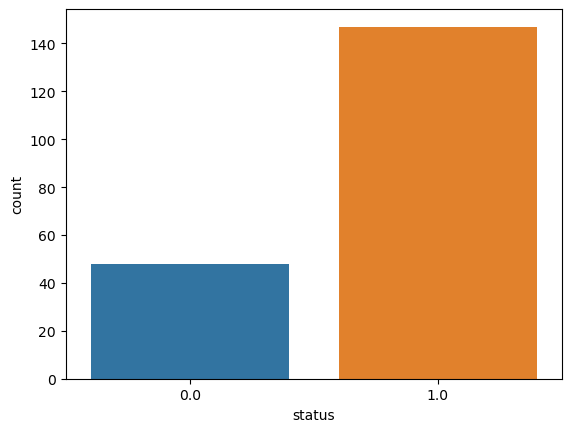

In [67]:
sns.countplot(x="status", data= df)

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

X = df.drop(columns="status", axis=1).values
y = df["status"].values
feature_names.remove("status")

std = StandardScaler()
X = std.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= test_split, random_state=rs)

kfold = StratifiedKFold(n_splits= folds, random_state= rs, shuffle=True)


In [69]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# Oversampling unbanlanced data
sm = SMOTE(random_state=rs) 
X_over, y_over = sm.fit_resample(X_train , y_train)

# Undersampling unbalanced data
tl = TomekLinks(sampling_strategy="auto")
X_under, y_under = tl.fit_resample(X_train, y_train)

In [70]:
import shap

def compute_shap(model, feature_names, X_train, explainer_ = 'kernel', num_samples = 50) -> DataFrame:
    
    shap.initjs()

    #Defining and executing explainer
    sample = shap.sample(X_train, 100, random_state=rs)
    explainer = shap.TreeExplainer(model) if explainer_ == 'tree' else shap.KernelExplainer(model.predict, sample)
    shap_values = explainer.shap_values(sample)
    
    #Calculate shap_values impact of each feature
    shap_sum = np.abs(shap_values).mean(axis=0)

    #Make a dataframe of each feature and shap_value
    importance_df = pd.DataFrame([feature_names, shap_sum.tolist()]).T
    importance_df.columns = ['feature', 'importance']
    importance_df = importance_df.sort_values('importance', ascending=False)
    
    features = importance_df['feature'].index.to_list()
    
    shap.summary_plot(shap_values, sample, feature_names=feature_names)
    
    return features

In [71]:
def feature_selection(model, ordered_features, n_min = -1, threshold=0.001):
    
    features_list = ordered_features[:n_min].copy() if n_min >= 0 else ordered_features.copy()
    
    best_features = None
    best_acc = 0
    current = features_list.copy()

    for feature in features_list[1:][::-1]:
        current.remove(feature)
        
        X_train_shap = X_train[:, current]
        X_test_shap = X_test[:, current]
        
        model.fit(X_train_shap, y_train)
        y_pred = model.predict(X_test_shap)
        test_acc = accuracy_score(y_test, y_pred)
        
        if test_acc > best_acc-best_acc*threshold:
            best_acc = test_acc
            best_features = current.copy()
            print(f'Best accuracy: {best_acc} with {len(best_features)} features')
            
    print(f'Results: Best accuracy: {best_acc} with {best_features}')
    
    return best_features
    

In [85]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def run_test(models: list, X_train_ = X_train, y_train_= y_train ,X_test_ = X_test, y_test_ = y_test, cm = False, new_features = None):
    
    if new_features != None:
        print("New features: ", new_features, end="\n\n")
        
        X_train_ = X_train_[:,new_features]
        X_test_ = X_test_[:,new_features]
    
    for model_ in models:
        
        model_.fit(X_train_, y_train_)
        y_pred = model_.predict(X_test_)
        test_acc = accuracy_score(y_test_, y_pred)

        print(model_)
        print("Accuracy: ", test_acc, end="\n\n")
    
        if cm:
            matrix = ConfusionMatrixDisplay(confusion_matrix(y_test_, y_pred))
            matrix.plot()

In [73]:
from sklearn.svm import SVC

model = SVC(probability=True)

model.fit(X_train, y_train)

SVC(probability=True)

In [74]:
breast_genes_data = pd.read_csv("../bases/Breast_GSE38959.csv")

In [75]:
df = breast_genes_data.drop('samples', axis=1)
df.head(5)

,type,NM_004900,AA085955,NM_014616,AK092846,NM_001539,THC2450799,NM_006709,NM_000978,T12590,...,AF117899,A_24_P287526,THC2349421,THC2272949,NM_138411,THC2350949,CR600872,NM_016058,AF520801,NM_203414
0,triple_negative_breast_cancer,5.397972,4.878910,6.328569,4.562055,10.183883,4.377609,4.852302,12.097979,5.526607,...,7.357777,5.213975,4.454014,5.983366,4.632281,4.747501,4.507341,7.737400,4.499438,4.878910
1,triple_negative_breast_cancer,5.679156,7.108852,4.706115,6.219244,11.020998,4.627557,5.112524,13.290506,8.766883,...,7.352243,5.032044,4.683446,4.673856,4.490288,4.356829,6.351861,6.440282,4.362710,4.976353
2,triple_negative_breast_cancer,4.935842,7.060972,6.999370,4.579123,11.142480,4.514081,4.796740,13.039557,8.244181,...,7.336034,5.115805,4.567063,4.514081,4.438267,4.446520,6.302137,6.816790,4.421894,5.248685
3,triple_negative_breast_cancer,5.216894,6.815301,5.657906,4.438267,9.673847,4.511823,5.072225,13.277404,6.354835,...,7.206526,5.440784,4.583486,4.556824,4.681703,4.466248,6.630745,7.044292,4.358895,6.321352
4,triple_negative_breast_cancer,4.706115,4.465668,5.229207,6.245122,9.832268,4.422589,5.471139,13.268857,8.482841,...,7.626914,4.852302,4.837053,4.566795,4.920688,4.410083,5.453399,6.944313,4.496288,6.779711


(43, 33581)


<Axes: xlabel='type', ylabel='count'>

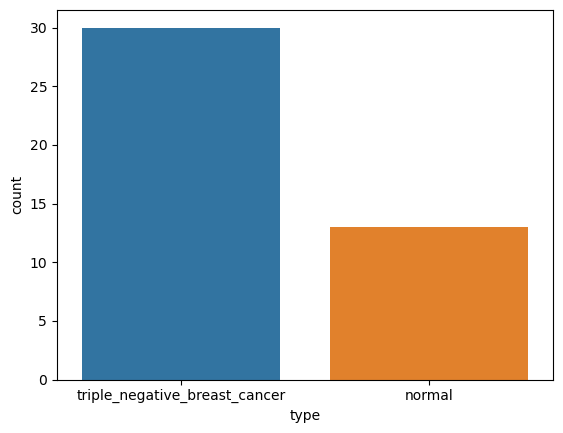

In [76]:
print(breast_genes_data.shape)
sns.countplot(x="type", data= breast_genes_data)

In [77]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

feature_names = df.columns.to_list()
feature_names.remove("type")

X = df.drop(columns="type", axis=1).values
y = df["type"].map({"normal":0, "triple_negative_breast_cancer":1}).values

std = StandardScaler()
X = std.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= test_split, random_state=rs)

In [78]:
X_train.shape

(30, 33579)

0.9230769230769231


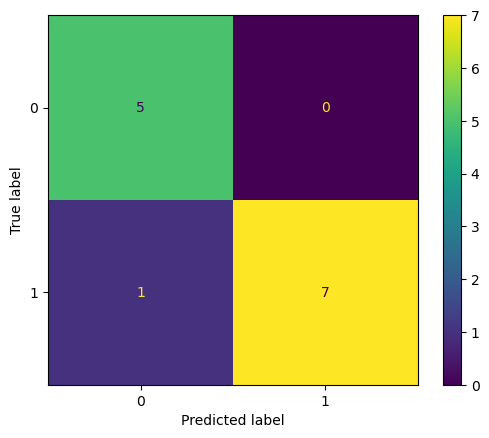

In [79]:
from xgboost import XGBClassifier

model = XGBClassifier()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))

matrix = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
matrix.plot()

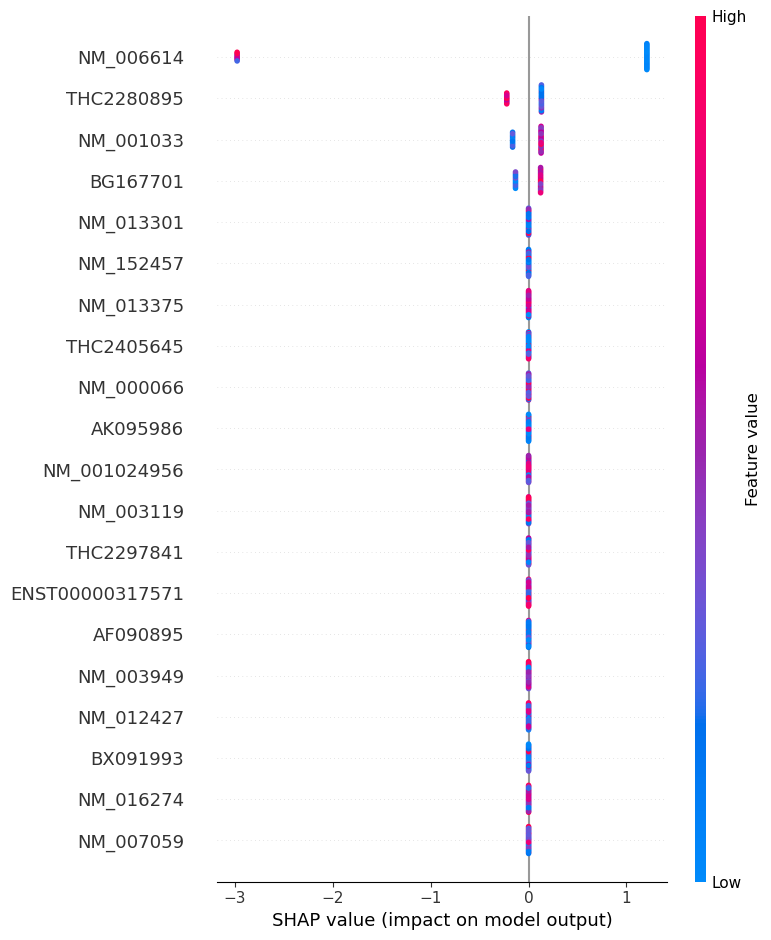

In [80]:
shap_features = compute_shap(model, feature_names, X_train, explainer_= 'tree')

In [81]:
xgb_features = feature_selection(model, shap_features, 5)

Best accuracy: 0.9230769230769231 with 4 features
Best accuracy: 0.9230769230769231 with 3 features
Best accuracy: 0.9230769230769231 with 2 features
Best accuracy: 0.9230769230769231 with 1 features
Results: Best accuracy: 0.9230769230769231 with [2127]


In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

models = [KNeighborsClassifier(), AdaBoostClassifier(), RandomForestClassifier(), MLPClassifier(verbose=0), LogisticRegression()]

for test_model in models:
    test_model.fit(X_train, y_train)
    y_pred = test_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print('\n',test_model)
    print('No Feature Selection Accuracy:', acc)
    test_features = feature_selection(test_model, shap_features, 5)
    run_test([test_model], cm= True, new_features=test_features)


In [103]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from shap.explainers._tree import InvalidModelError

modelos = [RandomForestClassifier(), GradientBoostingClassifier(), AdaBoostClassifier(), ExtraTreesClassifier(),
           LogisticRegression(), MLPClassifier(), DecisionTreeClassifier(), LGBMClassifier(), XGBClassifier()]

for modelo in modelos:
    try:
        modelo.fit(X_train, y_train)
        exp = shap.TreeExplainer(modelo)
        print("Modelo suportado: ", modelo.__class__.__name__)
    except InvalidModelError:
        print("Modelo não suportado: ", modelo.__class__.__name__)

Modelo suportado:  RandomForestClassifier
Modelo suportado:  GradientBoostingClassifier
Modelo não suportado:  AdaBoostClassifier
Modelo suportado:  ExtraTreesClassifier
Modelo não suportado:  LogisticRegression
Modelo não suportado:  MLPClassifier
Modelo suportado:  DecisionTreeClassifier
Modelo suportado:  LGBMClassifier
Modelo suportado:  XGBClassifier
